In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate
from tensorflow.keras.optimizers import Adam


# Load existing data
data_path = '/kaggle/input/8782-m/processed_data.csv'
data = pd.read_csv(data_path)

# Remove rows where 'context' starts with 'http'
data = data[~data['context'].str.startswith('http')]

# Convert text to lowercase
data['query'] = data['query'].str.lower()
data['context'] = data['context'].str.lower()

# Concatenate contexts for the same query
data = data.groupby('query')['context'].apply(lambda x: ' '.join(x)).reset_index()

data = pd.concat([data] * 80, ignore_index=True)


# Read new dialogue data from dialogs.txt
with open('/kaggle/input/8767-m/dialogs.txt', 'r') as file:
    dialogues = file.readlines()

# Process the dialogues into query and context pairs
dialogues_data = []
for i in range(0, len(dialogues), 2):
    query = dialogues[i].strip().lower()
    if i + 1 < len(dialogues):
        context = dialogues[i + 1].strip().lower()
        dialogues_data.append({'query': query, 'context': context})

dialogues_df = pd.DataFrame(dialogues_data)

dialogues_df = pd.concat([dialogues_df] * 3, ignore_index=True)

print(len(dialogues_df))

print(len(data))

dialogues_df



5586
8240


,query,context
0,"hi, how are you doing?\ti'm fine. how about yo...",i'm fine. how about yourself?\ti'm pretty good...
1,i'm pretty good. thanks for asking.\tno proble...,no problem. so how have you been?\ti've been g...
2,i've been great. what about you?\ti've been go...,i've been good. i'm in school right now.\twhat...
3,what school do you go to?\ti go to pcc.,i go to pcc.\tdo you like it there?
4,do you like it there?\tit's okay. it's a reall...,it's okay. it's a really big campus.\tgood luc...
...,...,...
5581,there's something wrong with my right hand.\tw...,what's wrong with it?\tit aches most of the time.
5582,it aches most of the time.\twhat do you think ...,what do you think it is?\ti don't know. i thin...
5583,i don't know. i think it's old age.\tif it's o...,"if it's old age, why don't both of your hands ..."
5584,that's a good question. maybe it's not old age...,are you right-handed?\tyes. all my life.


In [41]:
# Combine existing data with new dialogues
data = pd.concat([dialogues_df, data], ignore_index=True)

# Add start and end tokens
start_token = '<start>'
end_token = '<end>'

data['query'] = data['query'].apply(lambda x: f"{start_token} {x} {end_token}")
data['context'] = data['context'].apply(lambda x: f"{start_token} {x} {end_token}")

# Split data into questions (queries) and answers (contexts)
questions = data['query'].tolist()
answers = data['context'].tolist()

# Initialize tokenizer and fit on texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)

# Manually add start and end tokens to the word index
tokenizer.word_index[start_token] = len(tokenizer.word_index) + 1
tokenizer.word_index[end_token] = len(tokenizer.word_index) + 1

# Convert texts to sequences
questions_seq = tokenizer.texts_to_sequences(questions)
answers_seq = tokenizer.texts_to_sequences(answers)

# Determine maximum lengths for questions and answers
max_question_len = 35
max_answer_len = 850

# Pad sequences for questions and answers
questions_padded = pad_sequences(questions_seq, maxlen=max_question_len, padding='post')
answers_padded = pad_sequences(answers_seq, maxlen=max_answer_len, padding='post')

# Define vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Define model parameters
embedding_dim = 256
lstm_units = 150

# Define the encoder inputs
encoder_inputs = Input(shape=(max_question_len,))

# Embedding layer
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)

# LSTM layer
encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Self-attention layer
attention = Attention()
attention_outputs = attention([encoder_outputs, encoder_outputs])

# Optional: Concatenate attention outputs with LSTM outputs
encoder_outputs = Concatenate()([encoder_outputs, attention_outputs])

encoder_states = [state_h, state_c]

# Define the decoder
decoder_inputs = Input(shape=(max_answer_len,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model with a lower learning rate
learning_rate = 0.001  # Set your desired learning rate here
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prepare decoder input data
decoder_input_data = np.zeros_like(answers_padded)
decoder_input_data[:, 1:] = answers_padded[:, :-1]  # Shift right
decoder_target_data = np.expand_dims(answers_padded, -1)  # Add channel dimension

# Train the model
history = model.fit(
    [questions_padded, decoder_input_data],
    decoder_target_data,
    batch_size=16,
    epochs=14,
    validation_split=0.2
)

# Save the model
model.save('chatbot_model_new.h5')



Epoch 1/14
692/692 ━━━━━━━━━━━━━━━━━━━━ 53s 74ms/step - accuracy: 0.7078 - loss: 2.3744 - val_accuracy: 0.5530 - val_loss: 2.4438
Epoch 2/14
692/692 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.7874 - loss: 1.1421 - val_accuracy: 0.6787 - val_loss: 1.5810
Epoch 3/14
692/692 ━━━━━━━━━━━━━━━━━━━━ 50s 73ms/step - accuracy: 0.8455 - loss: 0.7591 - val_accuracy: 0.7658 - val_loss: 1.0848
Epoch 4/14
692/692 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.8877 - loss: 0.5340 - val_accuracy: 0.8362 - val_loss: 0.7667
Epoch 5/14
692/692 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - accuracy: 0.9173 - loss: 0.3946 - val_accuracy: 0.8808 - val_loss: 0.5664
Epoch 6/14
692/692 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - accuracy: 0.9399 - loss: 0.2945 - val_accuracy: 0.9172 - val_loss: 0.4126
Epoch 7/14
692/692 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - accuracy: 0.9555 - loss: 0.2252 - val_accuracy: 0.9377 - val_loss: 0.3184
Epoch 8/14
692/692 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - accuracy: 0.9696 - loss: 0.1651 - 

In [57]:
from tensorflow.keras.models import load_model


model = load_model('/kaggle/working/chatbot_model_new.h5')

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 850)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, 35, 256)   │  1,145,856 │ input_layer_22[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (None, 850, 256)  │  1,145,856 │ input_layer_23[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ [(None, 35, 150), │    244,200 │ embedding_22[0][… │
│                     │ (None, 150),      │            │                   │
│                     │ (None, 150)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ [(None, 850,      │    244,200 │ embedding_23[0][… │
│                     │ 150), (None,      │            │ lstm_22[0][1],    │
│                     │ 150), (None,      │            │ lstm_22[0][2]     │
│                     │ 150)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 850, 4476) │    675,876 │ lstm_23[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,455,990 (13.18 MB)

 Trainable params: 3,455,988 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

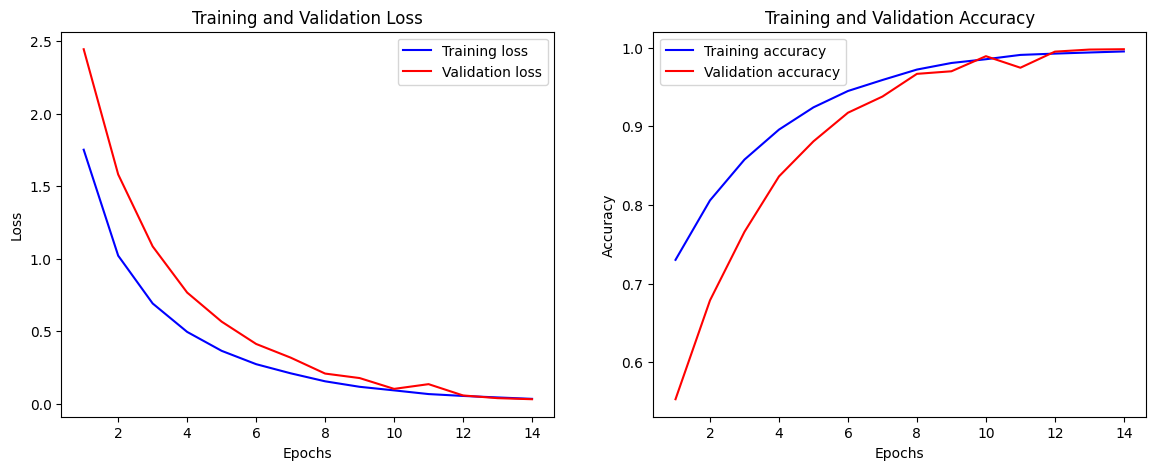

In [42]:
import matplotlib.pyplot as plt

# Extract loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract accuracy values if available
if 'accuracy' in history.history:
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values if available
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.show()


In [43]:

# Define a function to generate responses
def generate_response(input_text):
    input_seq = tokenizer.texts_to_sequences([f"{start_token} {input_text.lower()} {end_token}"])
    input_seq = pad_sequences(input_seq, maxlen=max_question_len, padding='post')
    
    decoder_input_seq = np.zeros((1, max_answer_len))
    decoder_input_seq[0, 0] = tokenizer.word_index[start_token]
    
    output_seq = np.zeros((1, max_answer_len))
    
    for t in range(1, max_answer_len):
        output_pred = model.predict([input_seq, decoder_input_seq])
        word_index = np.argmax(output_pred[0, t-1, :])
        
        if word_index == tokenizer.word_index[end_token]:
            break
        
        output_seq[0, t] = word_index
        decoder_input_seq[0, t] = word_index

    response = tokenizer.sequences_to_texts(output_seq)[0]
    return response.replace(f"{start_token} ", "").replace(f" {end_token}", "")

# Test the chatbot
test_input = "PayPal (Worldwide)?"
print(generate_response(test_input))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

In [44]:
test_input = "Apple Pay (Worldwide)?"
print(generate_response(test_input))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [45]:
test_input = "Create an account in payever?"
print(generate_response(test_input))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━